## Installing Necessary Packages

In [45]:
# Installing XGBoost

!pip install xgboost

## Importing necessary libraries


In [199]:
#Dataframe manipulation and analysis libraries
import pandas as pd
import numpy as np

#Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci

#Library to filter warnings
import warnings
warnings.filterwarnings('ignore')

#Multicolinearity Test Package
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data preperation Libraries
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV

#Feature Decomposition lIbrary 
from sklearn.decomposition import PCA

# Model Evaluation Libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
 
#Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost 

#Clustering Library
from sklearn.cluster import KMeans

#Learning Curve Analysis Library
from sklearn.model_selection import learning_curve

### Loading the dataframe


In [118]:
df = pd.read_excel('Rocket Loans.xlsx')
df = df.drop('Loan_ID',axis = 1)
df.head()

,Sex,Age,Married,No. of People in the Family,Qualification,Self_Employed,Loan_Bearer_Income,Loan_Cobearer_Income,Amount Disbursed,Loan_Tenure,Credit_Score,Location_type,Loan_Status
0,Male,33,No,0,Graduate,No,5849,0.0,108.0,360.0,1.0,Urban,Y
1,Male,34,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,31,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,33,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,48,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [119]:
def encoder(cols):
    labelencoder = LabelEncoder()
    for col in cols:
        print(col)
        df[col] = labelencoder.fit_transform(df[col])
    return df.head()

In [120]:
encoder(['Sex','Married','Qualification','Self_Employed','Location_type','Loan_Status'])

Sex
Married
Qualification
Self_Employed
Location_type
Loan_Status


,Sex,Age,Married,No. of People in the Family,Qualification,Self_Employed,Loan_Bearer_Income,Loan_Cobearer_Income,Amount Disbursed,Loan_Tenure,Credit_Score,Location_type,Loan_Status
0,1,33,0,0,0,0,5849,0.0,108.0,360.0,1.0,2,1
1,1,34,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,31,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,33,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,48,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


In [121]:
df["No. of People in the Family"].replace('3+',3,inplace = True)

## Problem statement

* Build a machine learning model which can classify the loan_status as yes or no based on given data

## Exploratory Data Analysis(EDA)

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Sex                          614 non-null    int32  
 1   Age                          614 non-null    int64  
 2   Married                      614 non-null    int32  
 3   No. of People in the Family  599 non-null    float64
 4   Qualification                614 non-null    int32  
 5   Self_Employed                614 non-null    int32  
 6   Loan_Bearer_Income           614 non-null    int64  
 7   Loan_Cobearer_Income         614 non-null    float64
 8   Amount Disbursed             593 non-null    float64
 9   Loan_Tenure                  600 non-null    float64
 10  Credit_Score                 564 non-null    float64
 11  Location_type                614 non-null    int32  
 12  Loan_Status                  614 non-null    int32  
dtypes: float64(5), int32

Analysis:
- There are 614  rows in the dataset
- There are 9 features
- There are  null records present in No. of People in the Family,Amount Disbursed,Loan_Tenure,Credit_Score  
- All values are not in the form of continous data
- Converted 'Sex','Married','Qualification','Self_Employed','Location_type','Loan_Status' through encoding

### Replacing Missing values

In [134]:
mode3 = df['No. of People in the Family'].mode() #mode3=0
mean8 = df['Amount Disbursed'].mean()            #mode8=120
mean9 = df['Loan_Tenure'].mean()
mean10 = df['Credit_Score'].mean()
print(mean8)
df['Amount Disbursed'] = df['Amount Disbursed'].fillna(mean8)
df['No. of People in the Family'] = df['No. of People in the Family'].fillna(0)
df['Loan_Tenure'] = df['Loan_Tenure'].fillna(mean9)
df['Credit_Score'] = df['Credit_Score'].fillna(mean10)

146.34738617200676


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Sex                          614 non-null    int32  
 1   Age                          614 non-null    int64  
 2   Married                      614 non-null    int32  
 3   No. of People in the Family  614 non-null    float64
 4   Qualification                614 non-null    int32  
 5   Self_Employed                614 non-null    int32  
 6   Loan_Bearer_Income           614 non-null    int64  
 7   Loan_Cobearer_Income         614 non-null    float64
 8   Amount Disbursed             614 non-null    float64
 9   Loan_Tenure                  614 non-null    float64
 10  Credit_Score                 614 non-null    float64
 11  Location_type                614 non-null    int32  
 12  Loan_Status                  614 non-null    int32  
dtypes: float64(5), int32

#### Descriptive analysis

In [136]:
df.describe()

,Sex,Age,Married,No. of People in the Family,Qualification,Self_Employed,Loan_Bearer_Income,Loan_Cobearer_Income,Amount Disbursed,Loan_Tenure,Credit_Score,Location_type,Loan_Status
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.838762,38.469055,0.657980,0.744300,0.218241,0.237785,5403.459283,1621.245798,146.347386,342.000000,0.842199,1.037459,0.687296
std,0.421752,8.124732,0.484971,1.009623,0.413389,0.534737,6109.041673,2926.248369,84.051763,64.372489,0.349681,0.787482,0.463973
min,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000,0.000000
25%,1.000000,32.000000,0.000000,0.000000,0.000000,0.000000,2877.500000,0.000000,100.250000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,39.000000,1.000000,0.000000,0.000000,0.000000,3812.500000,1188.500000,128.500000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,45.000000,1.000000,1.000000,0.000000,0.000000,5795.000000,2297.250000,164.750000,360.000000,1.000000,2.000000,1.000000
max,2.000000,52.000000,2.000000,3.000000,1.000000,2.000000,81000.000000,41667.000000,700.000000,480.000000,1.000000,2.000000,1.000000


#### Building custom summary function for indepth EDA report

In [137]:
def custom_summary(mydf):
    cols = []
    for i in df.columns:
        if mydf[i].dtype!=object:
            cols.append(i)
            
    result=pd.DataFrame(columns = cols,index=['datatype','count','min','Q1','Q2','Q3','max','mean','stddev',
                                             'skew','kurt','range','IQR','Skew_comment','kurt_comment',
                                             'Outlier_comment'])
    for i in result.columns:
        result.loc['datatype',i]=mydf[i].dtype
        result.loc['count',i] = mydf[i].count()
        result.loc['min',i] = mydf[i].min()
        result.loc['Q1',i] = mydf[i].quantile(0.25)
        result.loc['Q2',i] = mydf[i].quantile(0.5)
        result.loc['Q3',i] = mydf[i].quantile(0.75)
        result.loc['max',i] = mydf[i].quantile(1)
        result.loc['mean',i] = round(mydf[i].mean(),2)        #round to restrict the decimal places
        result.loc['stddev',i] = round(mydf[i].std(),2)
        result.loc['skew',i] = round(mydf[i].skew(),2)
        result.loc['kurt',i] = round(mydf[i].kurt(),2)
        result.loc['range',i] = mydf[i].max()-mydf[i].min()
        result.loc['IQR',i] = mydf[i].quantile(0.75)-mydf[i].quantile(0.25)
        
        #Adding commnets for skewness
        if result.loc['skew',i]<-1:
            sk_label = 'Highly negatively skewed'
        elif -1 < result.loc['skew',i] <= -0.5:
            sk_label = 'Moderately negatively skewed'
        elif -0.5 < result.loc['skew',i] <= 0:
            sk_label = 'Approximately normally distibuted(-ve)'
        elif 0 < result.loc['skew',i] <= 0.5:
            sk_label = 'Approximately normally distibuted(+ve)'    
        elif 0.5 < result.loc['skew',i] <= 1:
            sk_label = 'Moderately positively skewed'
        elif result.loc['skew',i] > 1:
            sk_label = 'Highly positively skewed'
        else:
            sk_label = 'error'
        
        result.loc['Skew_comment',i] = sk_label    
        
        #For kurt <-1 : Higly platykurtic
        #-1<to<-0.5 : mod platykurtuc
        #-0.5<to<0.5 : mesokurtic curve
        #0.5<to<1 : mod leptokurtuc
        #kurt>1 : Higly Leptkurtuc
        #else : error
        
        if result.loc['kurt',i]<-1:
            k_label = 'Higly platykurtic curve'
        elif -1 < result.loc['kurt',i] <= -0.5:
            k_label = 'Moderately platykurtic curve'
        elif -0.5 < result.loc['kurt',i] <= 0.5:
            k_label = 'Mesokurtic curve'  
        elif 0.5 < result.loc['kurt',i] <= 1:
            k_label = 'Moderately leptokurtic curve'
        elif result.loc['kurt',i] > 1:
            k_label = 'Highly leptokurtic curve'
        else:
            k_label = 'error'
        
        result.loc['kurt_comment',i] = k_label  
        
    #Adding comments for outliers
        
        lw = result.loc['Q1',i] - (1.5 * result.loc['IQR',i])
        uw = result.loc['Q3',i] + (1.5 * result.loc['IQR',i])
        
        if len([x for x in mydf[i] if x < lw or x > uw]) > 0:
            outlier_label = 'Have outliers'
        else:
            outlier_label = 'No outliers'
        
        result.loc['Outlier_comment',i] = outlier_label
        
    return result        

In [138]:
custom_summary(df)

,Sex,Age,Married,No. of People in the Family,Qualification,Self_Employed,Loan_Bearer_Income,Loan_Cobearer_Income,Amount Disbursed,Loan_Tenure,Credit_Score,Location_type,Loan_Status
datatype,int32,int64,int32,float64,int32,int32,int64,float64,float64,float64,float64,int32,int32
count,614,614,614,614,614,614,614,614,614,614,614,614,614
min,0,25,0,0.0,0,0,150,0.0,9.0,12.0,0.0,0,0
Q1,1.0,32.0,0.0,0.0,0.0,0.0,2877.5,0.0,100.25,360.0,1.0,0.0,0.0
Q2,1.0,39.0,1.0,0.0,0.0,0.0,3812.5,1188.5,128.5,360.0,1.0,1.0,1.0
Q3,1.0,45.0,1.0,1.0,0.0,0.0,5795.0,2297.25,164.75,360.0,1.0,2.0,1.0
max,2.0,52.0,2.0,3.0,1.0,2.0,81000.0,41667.0,700.0,480.0,1.0,2.0,1.0
mean,0.84,38.47,0.66,0.74,0.22,0.24,5403.46,1621.25,146.35,342.0,0.84,1.04,0.69
stddev,0.42,8.12,0.48,1.01,0.41,0.53,6109.04,2926.25,84.05,64.37,0.35,0.79,0.46
skew,-0.95,-0.01,-0.54,1.02,1.37,2.19,6.54,7.49,2.73,-2.39,-1.96,-0.07,-0.81


## Analysis

* There are outliers present in Sex,No. of People in the Family,Qualification,Self_Employed,Loan_Bearer_Income,Loan_Cobearer_Income,Amount Disbursed,Loan_Tenure,Credit_Score and we have to treat them
 

### Outlier Treatment

In [139]:
#Replacing Outliers 
def replace_outliers(mydf,col,method = 'Quartile',strategy = 'median'): #the other method is based on SD 
    if method == 'Quartile':
        Q1 = df[col].quantile(0.25)  #To calculate the quartile 1
        Q2 = df[col].quantile(0.5)
        Q3 = df[col].quantile(0.75)

        IQR = Q3-Q1
        lw = Q1-1.5*IQR
        uw = Q3+1.5*IQR
    elif method == 'standard_deviation':
        mean = mydf[col].mean()
        std = mydf[col].std()
        lw = mean - (2*std)   #2*std = 95% of our data points in normal distribution
        uw = mean + (2*std)
    else:
        print('Pass a correct method')
        
    #printing all the outliers
    outliers = mydf.loc[(mydf[col]<lw) | (mydf[col]>uw),col]
    outlier_density = round(len(outliers)/len(mydf),2)
    if len(outliers) == 0:
        print(f'feature {col} does not have any outliers')  #f stands for format string
    else:
        print(f'feature {col} have outliers')
        print(f'Total number of outliers in this {col} is {len(outliers)}')
        print(f'Outlier percentage in {col} is {outlier_density*100}%')
        
    
    if strategy == 'median':
        mydf.loc[(mydf[col] < lw),col] = Q1
        mydf.loc[(mydf[col] > uw),col] = Q3
    elif strategy == 'mean':
        mydf.loc[(mydf[col] < lw),col] = mean
        mydf.loc[(mydf[col] > uw),col] = mean
    else:
        print('Pass a correct statergy')
        
        
    return mydf

In [140]:
def odt_plot(mydf,col):
    f,(ax1,ax2) = plt.subplots(1,2,figsize = (25,8))
    #Descriptive statistics box plot
    sns.boxplot(mydf[col], ax=ax1)
    ax1.set_title(col + ' Boxplot')
    ax1.set_xlabel('Values')
    ax1.set_ylabel('Box plot')
    #Replacing the outliers
    mydf_out = replace_outliers(mydf,col)
    #plotting box plot without outliers
    sns.boxplot(mydf_out[col], ax=ax2)
    ax2.set_title(col + ' Boxplot')
    ax2.set_xlabel('Values')
    ax2.set_ylabel('Box plot')
    plt.show()

feature Sex have outliers
Total number of outliers in this Sex is 125
Outlier percentage in Sex is 20.0%


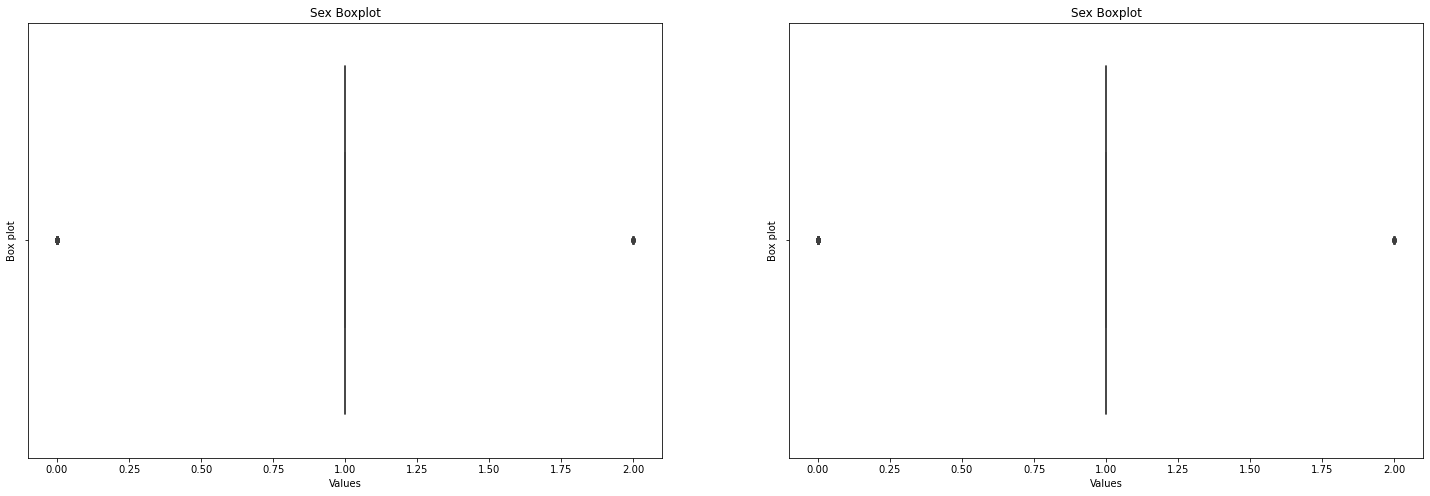

feature Age does not have any outliers


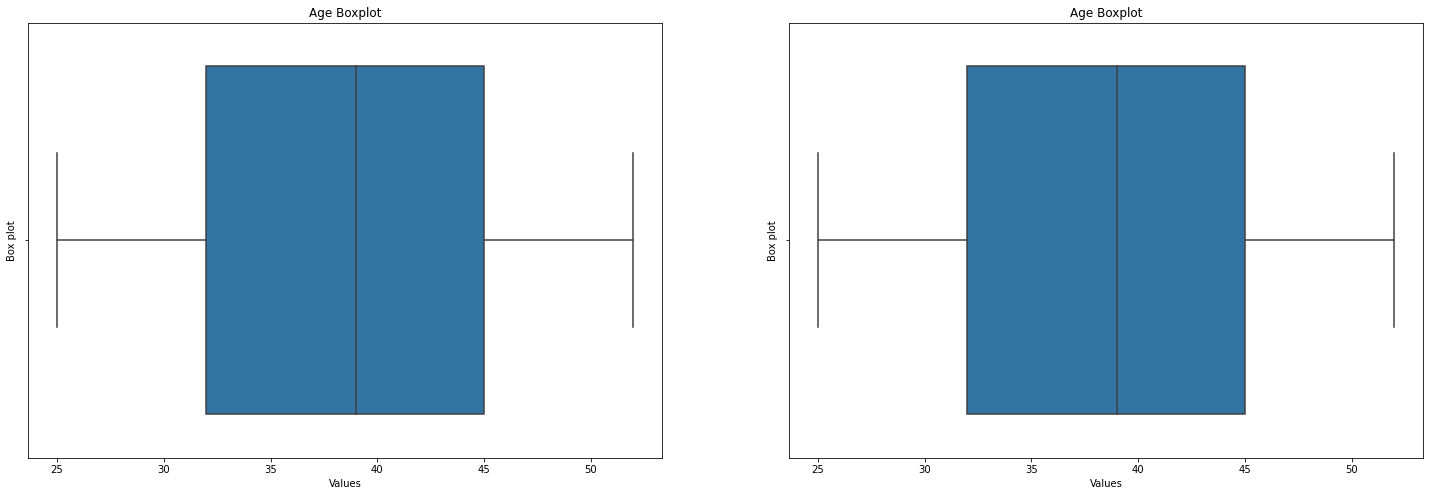

feature Married does not have any outliers


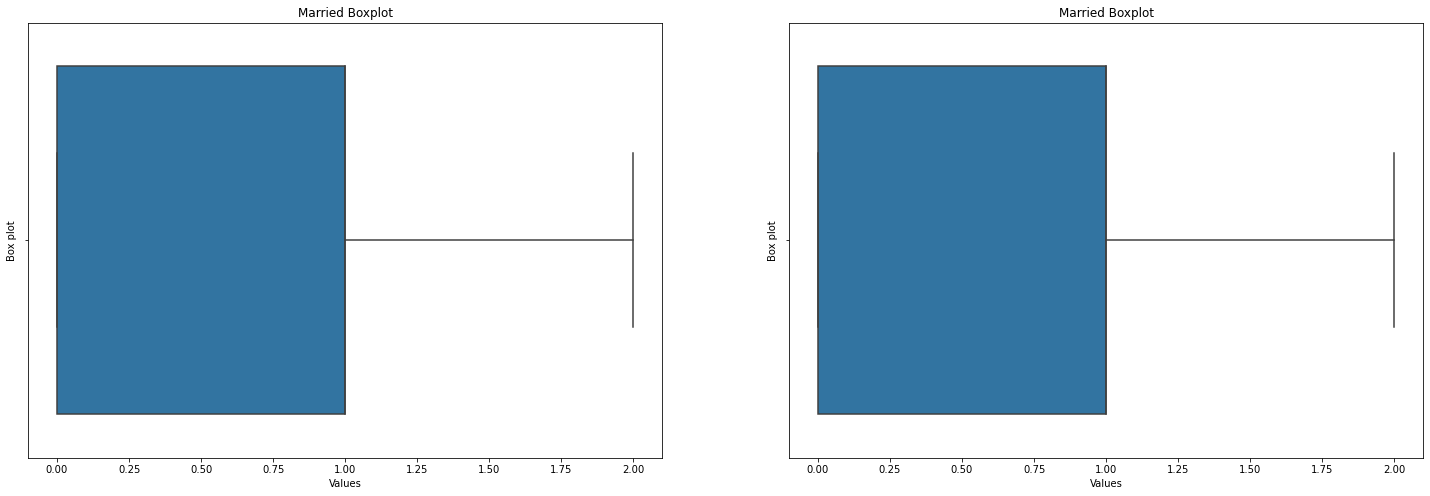

feature No. of People in the Family have outliers
Total number of outliers in this No. of People in the Family is 51
Outlier percentage in No. of People in the Family is 8.0%


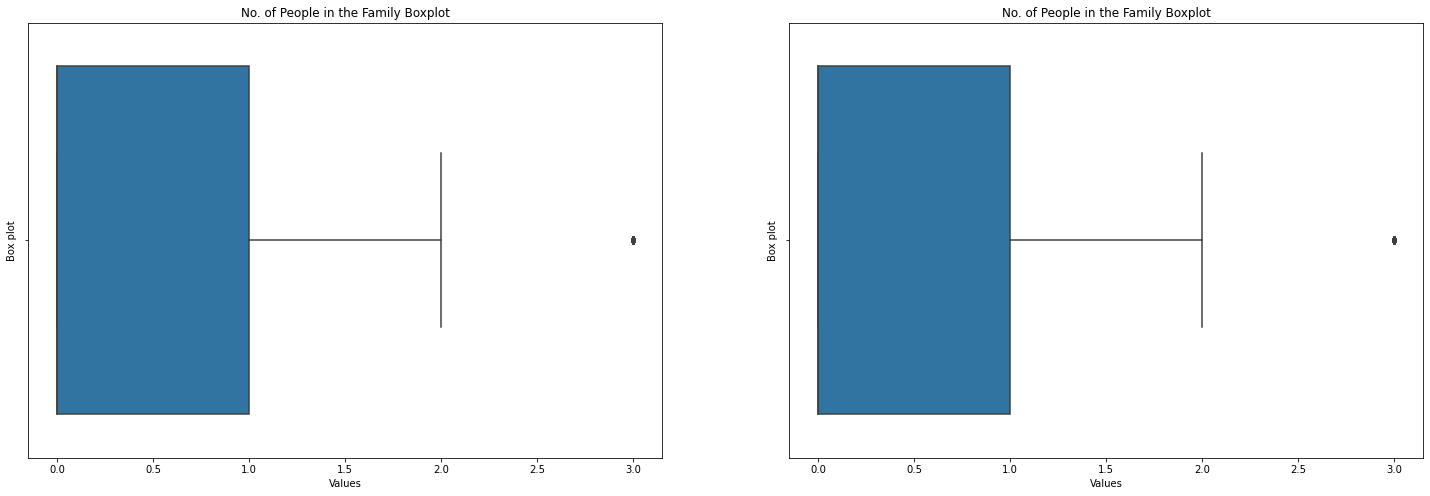

feature Qualification have outliers
Total number of outliers in this Qualification is 134
Outlier percentage in Qualification is 22.0%


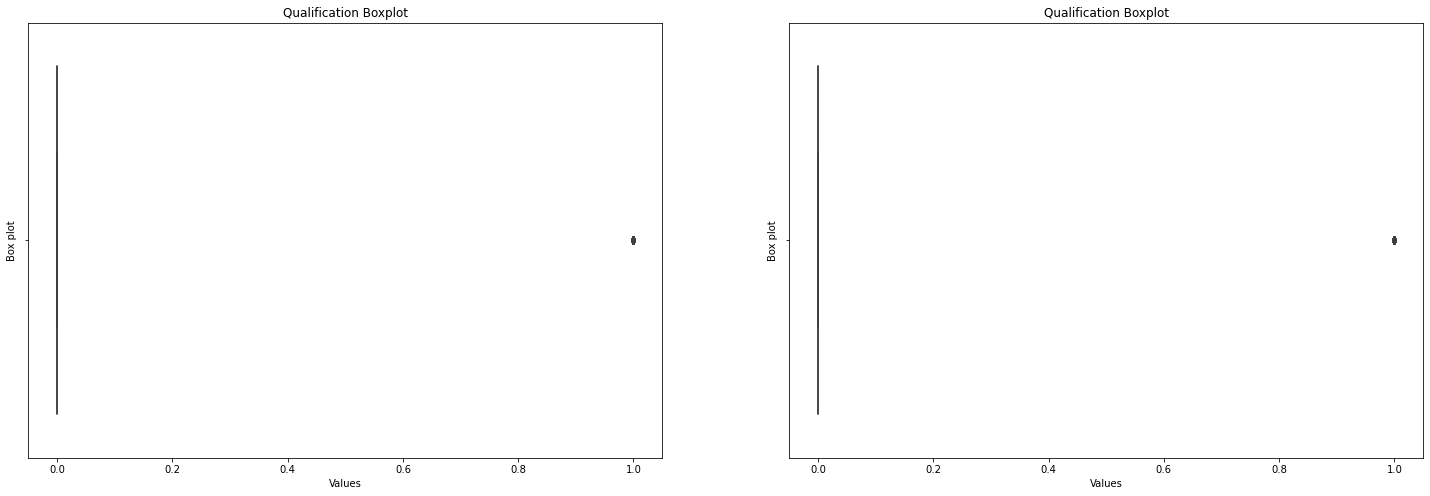

feature Self_Employed have outliers
Total number of outliers in this Self_Employed is 114
Outlier percentage in Self_Employed is 19.0%


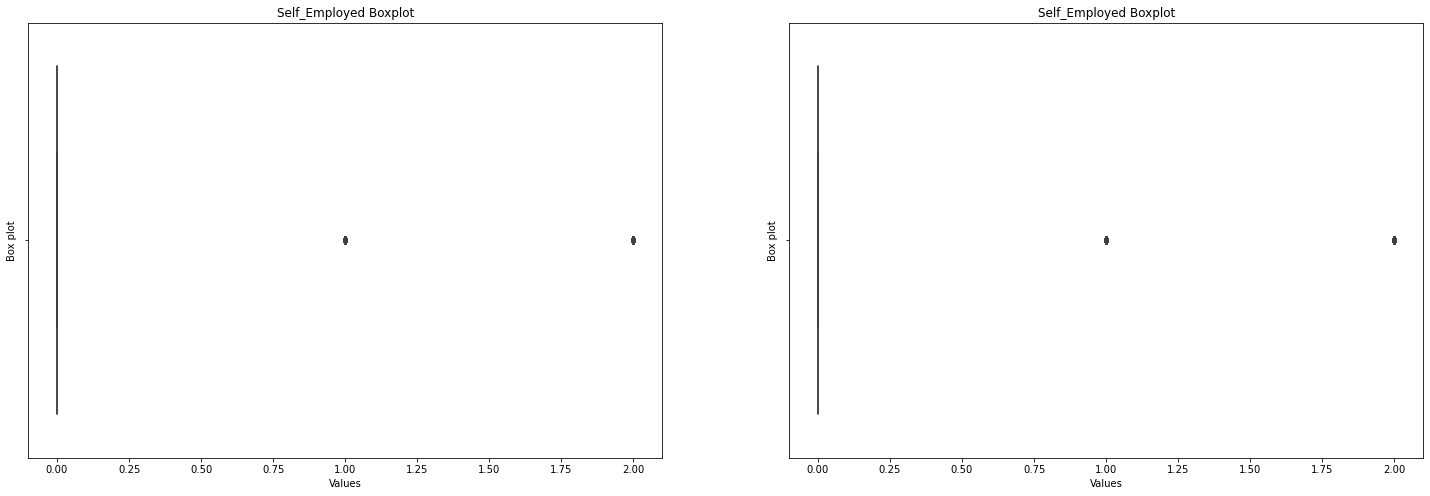

feature Loan_Bearer_Income have outliers
Total number of outliers in this Loan_Bearer_Income is 50
Outlier percentage in Loan_Bearer_Income is 8.0%


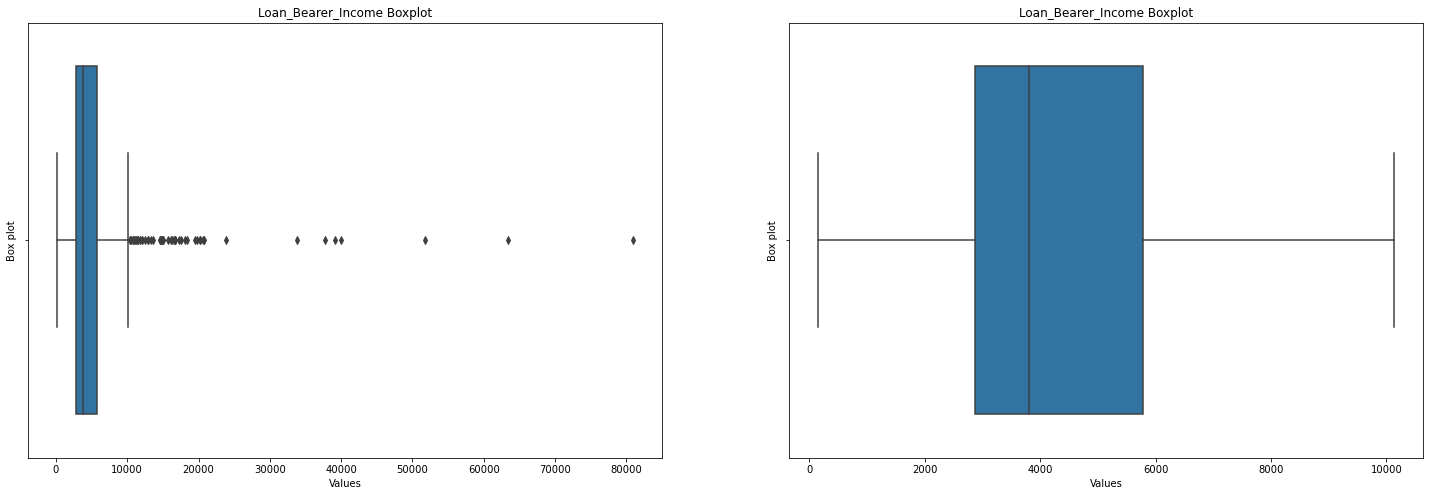

feature Loan_Cobearer_Income have outliers
Total number of outliers in this Loan_Cobearer_Income is 18
Outlier percentage in Loan_Cobearer_Income is 3.0%


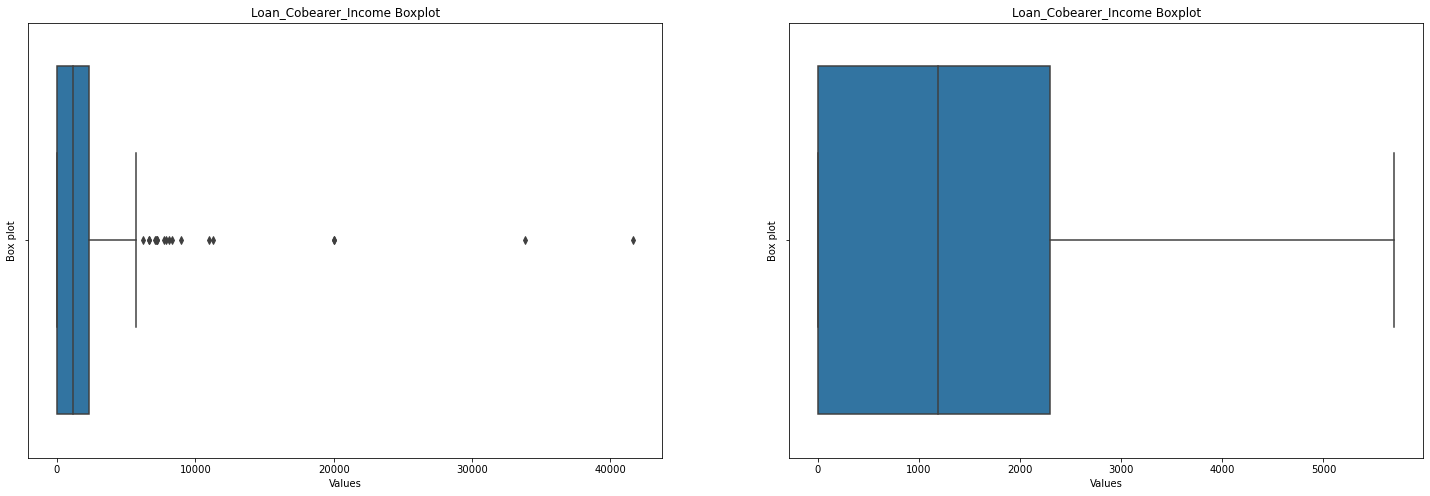

feature Amount Disbursed have outliers
Total number of outliers in this Amount Disbursed is 41
Outlier percentage in Amount Disbursed is 7.000000000000001%


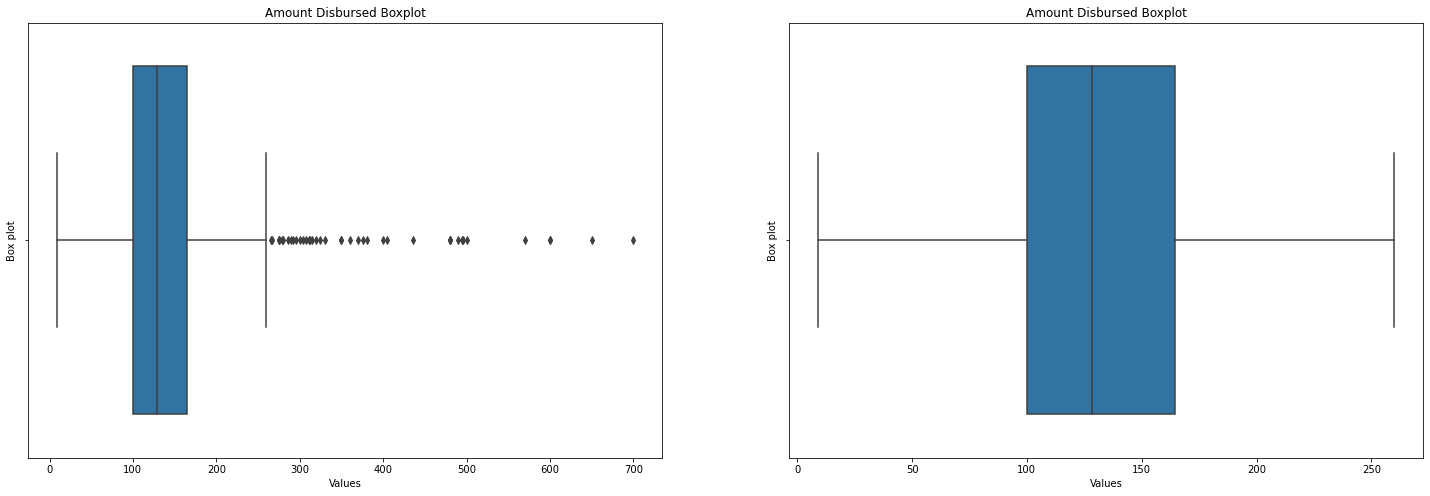

feature Loan_Tenure have outliers
Total number of outliers in this Loan_Tenure is 102
Outlier percentage in Loan_Tenure is 17.0%


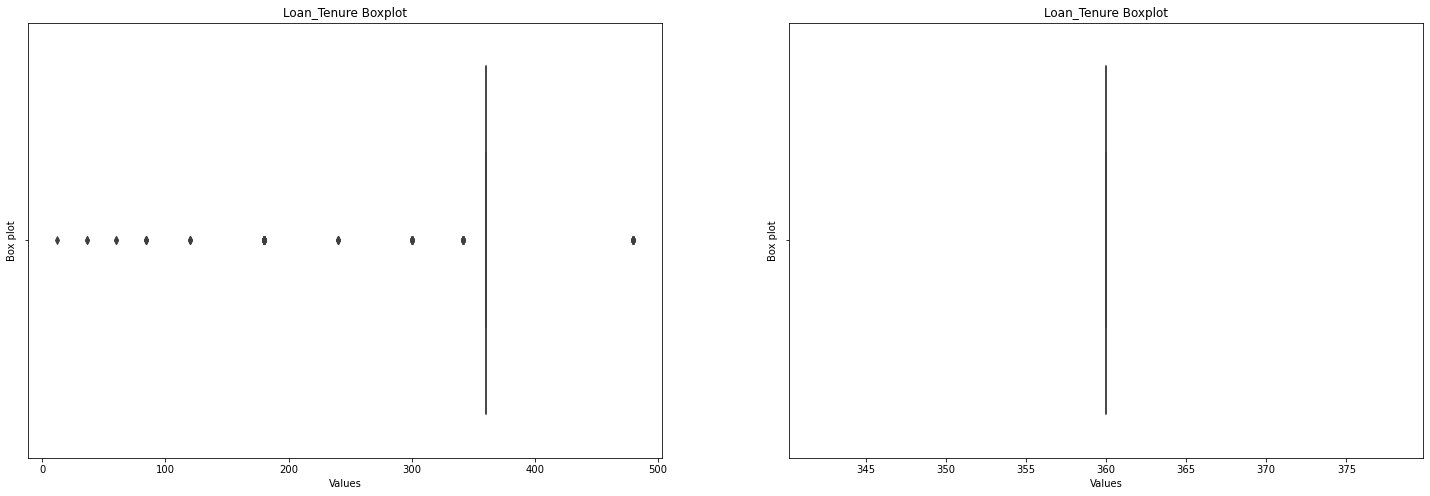

feature Credit_Score have outliers
Total number of outliers in this Credit_Score is 139
Outlier percentage in Credit_Score is 23.0%


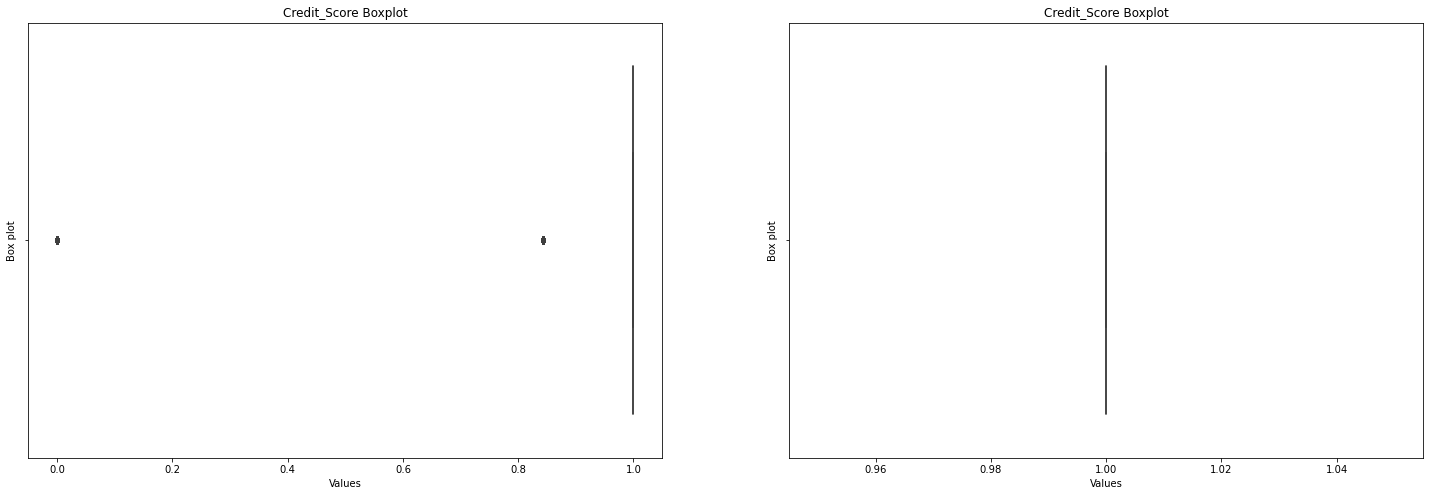

feature Location_type does not have any outliers


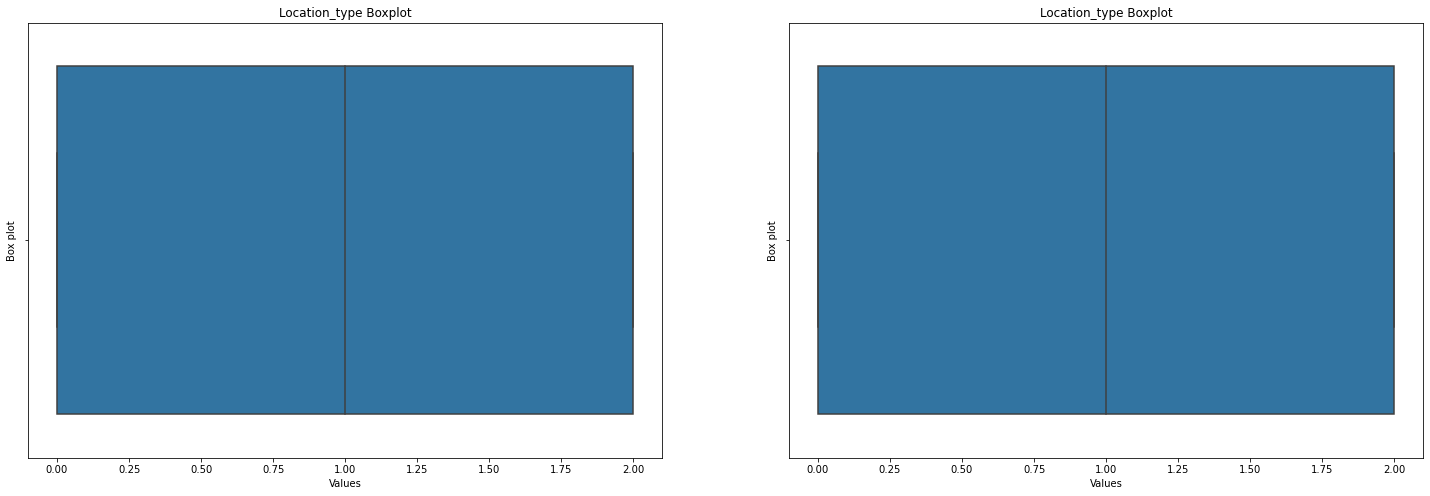

In [141]:
for col in df.drop('Loan_Status',axis=1).columns:
    odt_plot(df,col)

### Multivariate Analysis using regression

In [142]:
df.head()

,Sex,Age,Married,No. of People in the Family,Qualification,Self_Employed,Loan_Bearer_Income,Loan_Cobearer_Income,Amount Disbursed,Loan_Tenure,Credit_Score,Location_type,Loan_Status
0,1,33,0,0.0,0,0,5849.0,0.0,108.0,360.0,1.0,2,1
1,1,34,1,1.0,0,0,4583.0,1508.0,128.0,360.0,1.0,0,0
2,1,31,1,0.0,0,0,3000.0,0.0,66.0,360.0,1.0,2,1
3,1,33,1,0.0,0,0,2583.0,2358.0,120.0,360.0,1.0,2,1
4,1,48,0,0.0,0,0,6000.0,0.0,141.0,360.0,1.0,2,1


In [143]:
df.value_counts('Qualification')

Qualification
0    614
dtype: int64

Sex
Age
Married
No. of People in the Family
Qualification
Self_Employed
Loan_Bearer_Income
Loan_Cobearer_Income
Amount Disbursed
Loan_Tenure
Credit_Score
Location_type
Loan_Status


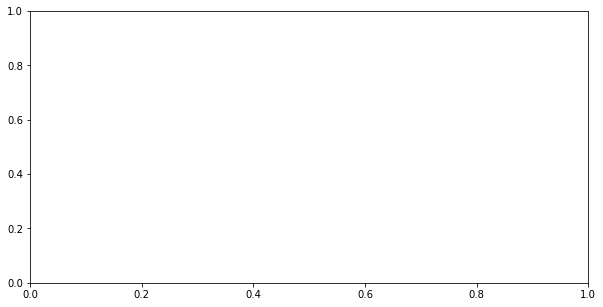

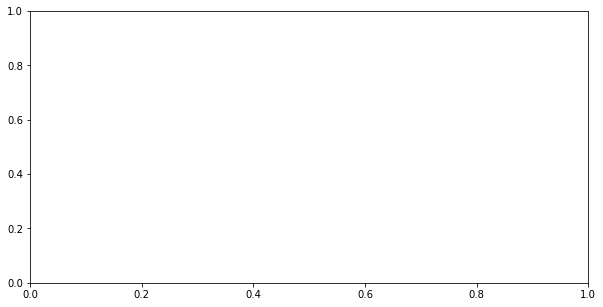

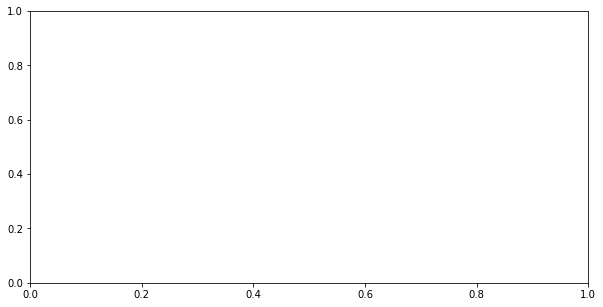

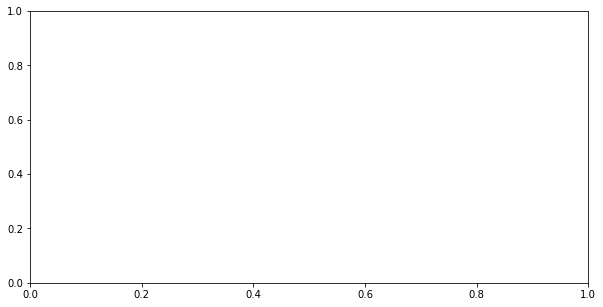

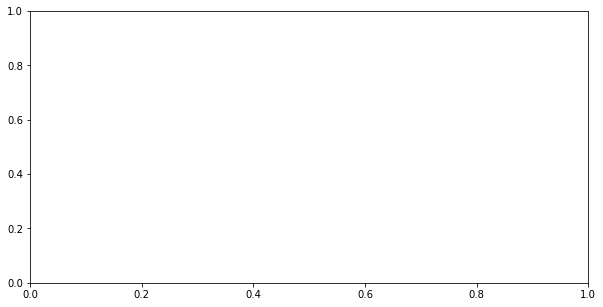

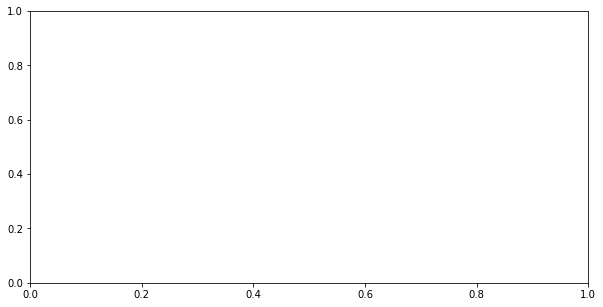

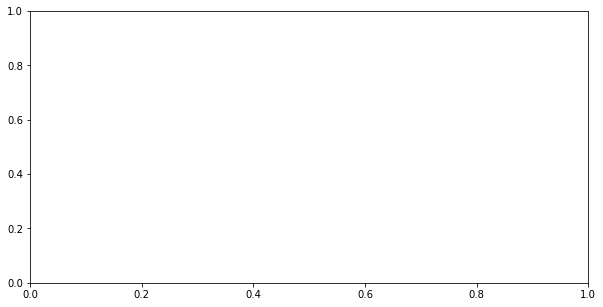

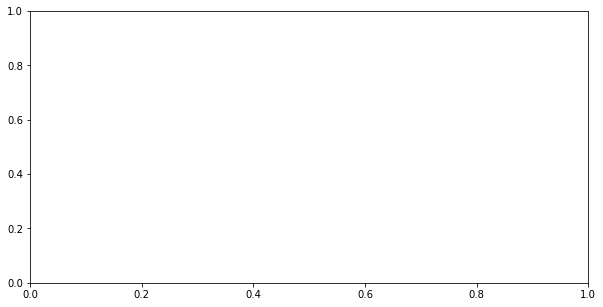

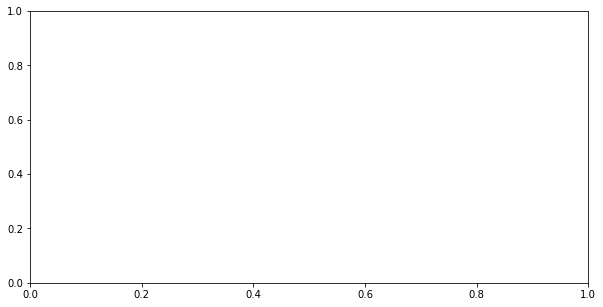

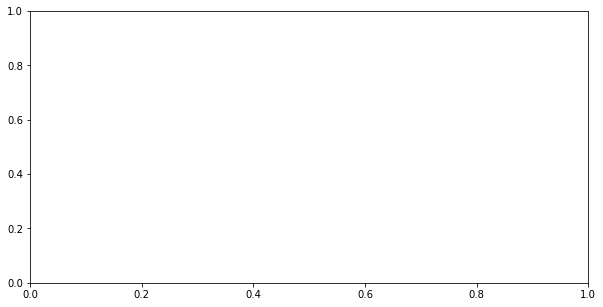

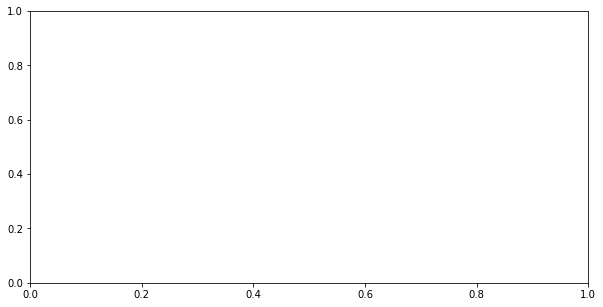

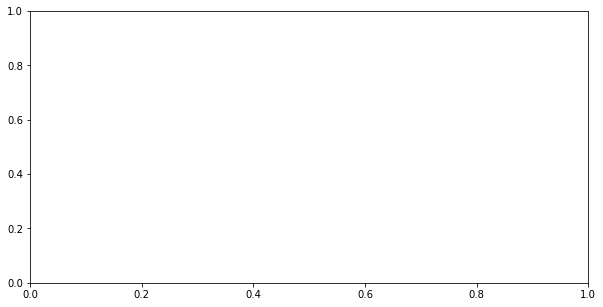

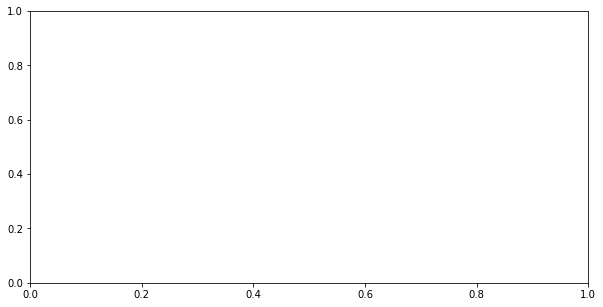

In [144]:
for col in df.columns:
    if col != 'Loan_status':
        print(col)
        fig,axdtypes= plt.subplots(figsize = (10,5))
        sns.regplot(x = df[col], y = df['Loan_Status'], ax=ax1).set_title(f'Relationship between {col} and Loan_Status')

### Analysis

1. Cement and Strength have positive correlation
2. Slag and Strength have a mild positive correlation
3. Ash and Strength have a mild negative correlation
4. Water and Strength have  negative correlation
5. Superplastic and Strength have positive correlation
6. Coarseagg and Strength have a mild negative correlation
7. Fineagg and Strength have a mild negative correlation
8. Age and Strength have positive correlation

What will happen if you check the multicollinearity for a regression problem

## Mullticolinearity check - Stage1:

-  correaltion heatmap


<AxesSubplot:>

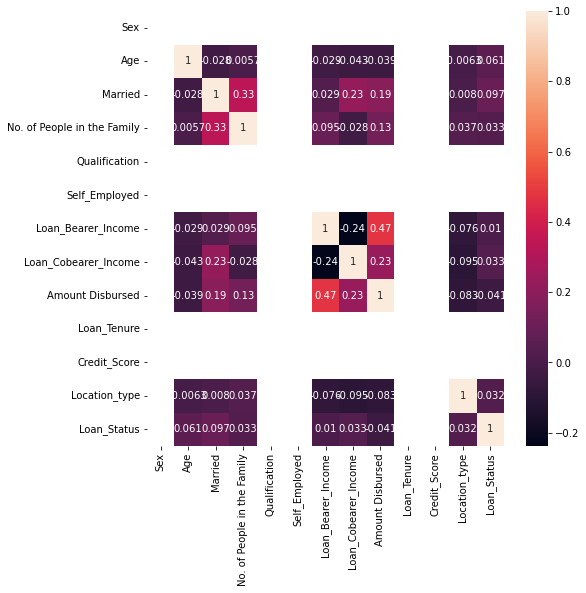

In [158]:
corr = df.corr()
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(corr,annot = True)

#### Analysis:

The pairs of independent variables having correlation greater than 30%
1. Cement and ash (-40%)
2. Slag and ash (-32%)
3. ash and superplastic (44%)
4. water and superplastic (-67%)
5. water and fineagg (-43%)
    - Many independent features have colinearity greater than 30% which indicates that there is a chance of multicolinearity.

## Mullticolinearity test - Stage 2

- Variance Inflating Factor(VIF)
- Formula for VIF = 1/(1-r2)
    1. Regress every independent variable with each other and find the r2 score4
    2. find out VIF using above formula
    3. if VIF is more than 5 for any independent variable we can conclude that multicolinearity exist
        - We are setting vif as 5 coz : vif 5 arrives when r2score is set at 80% 

In [159]:
def VIF(independent_variables):
    vif = pd.DataFrame()
    vif['vif'] = [variance_inflation_factor(independent_variables.values,i) for i in range (independent_variables.shape[1])]
    vif['independent_variables'] = independent_variables.columns
    vif = vif.sort_values(['vif'], ascending=[False])
    return vif

In [161]:
VIF(df.drop('Loan_Status',axis = 1))

,vif,independent_variables
8,1.566032,Amount Disbursed
6,1.553595,Loan_Bearer_Income
7,1.339314,Loan_Cobearer_Income
2,1.215875,Married
3,1.152963,No. of People in the Family
11,1.022843,Location_type
1,1.004268,Age
0,0.000000,Sex
9,0.000000,Loan_Tenure
10,0.000000,Credit_Score


Analysis: List all the features which has scores greater than 5
1. Cement
2. Water
3. Superplastic
4. coarseagg
5. fineagg
    - So we can conclude multicollinearity exist

### Correaltion with Target feature

In [145]:
def CWT(dataframe,Tcol):
    independent_variables = dataframe.drop(Tcol,axis = 1).columns
    corr_result = []
    for col in independent_variables:
        corr_result.append(dataframe[Tcol].corr(dataframe[col]))
    result = pd.DataFrame([independent_variables,corr_result],index = ['independent_variables','Correlation']).T
    #we have written .T at the end of the line to perform Transpose action
    return result.sort_values(by='Correlation',ascending = False)

In [146]:
CWT(df,'Loan_Status')

,independent_variables,Correlation
2,Married,0.096657
1,Age,0.061043
7,Loan_Cobearer_Income,0.033237
3,No. of People in the Family,0.032536
11,Location_type,0.032112
6,Loan_Bearer_Income,0.010462
8,Amount Disbursed,-0.040674
0,Sex,NaN
4,Qualification,NaN
5,Self_Employed,NaN


#### Analysis: The 5 most variables with higher corelation with Target variable in sequence are
            -age,cement,superplasitc,water,fineagg 

## Principal Component Analysis (PCA)

In [17]:
def PCA_1(x):
    n_comp = len(x.columns)
    scalar = StandardScaler()
    x = scalar.fit_transform(x)
    
    # Applying PCA
    
    for i in range(1,n_comp):
        pca = PCA(n_components = i)
        p_comp = pca.fit_transform(x)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if evr[i-1] > 0.9 :
            n_components = i
            break
    print('Explained Variance Ratio After PCA is : ',evr)
    
    # Creating PCA Dataframe
    
    col = []
    for j in range(1,n_components + 1):
        col.append('PC_' + str(j))
    pca_df = pd.DataFrame(p_comp,columns = col)
    return pca_df

In [18]:
transformed_df = PCA_1(df.drop('strength',axis = 1))

Explained Variance Ratio After PCA is :  [0.27182784 0.44776951 0.61076485 0.73733075 0.86207842 0.97452865]


In [19]:
transformed_df
#in original Dataframe there were 8 features and in PCA it has been reduced to 6 and with an info gain of 97%

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,1.826467,1.284669,-1.306398,-0.071238,-0.534151,-0.790446
1,-1.870787,-0.595629,-1.096613,-1.296651,-0.129022,-0.489721
2,-0.749866,-0.463901,-0.525517,0.698966,-0.783847,0.672137
3,2.776191,0.585938,-0.467626,0.036635,0.034228,0.865712
4,0.907764,0.917339,-0.890205,-1.155748,0.415338,-1.133230
...,...,...,...,...,...,...
1025,-1.731743,0.003980,-1.539754,-0.026398,0.016544,1.020793
1026,-1.615369,-0.132366,3.418087,0.456733,-1.591638,0.297913
1027,-0.505268,1.293797,0.235763,0.108114,0.073852,0.754882
1028,2.694112,-0.308213,0.078722,0.841495,0.734884,1.093212


### Joining PCA Features with Target Feature

In [20]:
transformed_df = transformed_df.join(df['strength'], how = 'left')  #how is the type of join performed here it is left joint
transformed_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,strength
0,1.826467,1.284669,-1.306398,-0.071238,-0.534151,-0.790446,29.89
1,-1.870787,-0.595629,-1.096613,-1.296651,-0.129022,-0.489721,23.51
2,-0.749866,-0.463901,-0.525517,0.698966,-0.783847,0.672137,29.22
3,2.776191,0.585938,-0.467626,0.036635,0.034228,0.865712,45.85
4,0.907764,0.917339,-0.890205,-1.155748,0.415338,-1.133230,18.29


## Model Building

1. Train Test Split
2. Cross Validation
3. Hyper-Parameter Tuning

## Train Test Split

In [147]:
def train_and_test_split(dataframe,tcol,testsize = 0.3):
    x = dataframe.drop(tcol,axis = 1)
    y = dataframe[tcol]
    return train_test_split(x,y,test_size = testsize,random_state = 1)

In [193]:
def model_builder(model_name,estimator,dataframe,tcol): 
    x_train,x_test,y_train,y_test = train_and_test_split(dataframe,tcol)        
    estimator.fit(x_train,y_train)
    y_pred = estimator.predict(x_test)
    #accuracy = accuracy_score(y_train,y_pred)
    prec_score = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    F1 = f1_score(y_test,y_pred)
    acc = accuracy_score(y_test, y_pred)
     
    return [model_name,acc,prec_score,recall,F1]


In [194]:
model_builder(model_name = 'Log Regression',estimator = LogisticRegression(),dataframe = df,tcol = 'Loan_Status')

['Log Regression',
 0.6702702702702703,
 0.6702702702702703,
 1.0,
 0.8025889967637541]

In [195]:
def multiple_models(dataframe,t_col):
    col_names=['Model Name','accuracy score','precision score','recall score','F1 score']
    result = pd.DataFrame(columns = col_names)
    result.loc[len(result)] = model_builder('Log Regression',LogisticRegression(),df,'Loan_Status')
    result.loc[len(result)] = model_builder('Decision Tree Classifier',DecisionTreeClassifier(),df,'Loan_Status')
    #result.loc[len(result)] = model_builder('Lasso',Lasso(),df,'Loan_Status')
    #result.loc[len(result)] = model_builder('Ridge',Ridge(),df,'Loan_Status')
    result.loc[len(result)] = model_builder('KNeighborsClassifier',KNeighborsClassifier(),df,'Loan_Status')
    result.loc[len(result)] = model_builder('SVC',SVC(),df,'Loan_Status')
    result.loc[len(result)] = model_builder('Random Forest Classifier',RandomForestClassifier(),df,'Loan_Status')
    result.loc[len(result)] = model_builder('AdaBoost Classifier',AdaBoostClassifier(),df,'Loan_Status')
    result.loc[len(result)] = model_builder('Gradient Boost Classifier',GradientBoostingClassifier(),df,'Loan_Status')
    result.loc[len(result)] = model_builder('XGB Classifier',XGBClassifier(),df,'Loan_Status')
    
    return result.sort_values(by = 'accuracy score',ascending = False)

In [196]:
multiple_models(df,'Loan_Status')

,Model Name,accuracy score,precision score,recall score,F1 score
6,Gradient Boost Classifier,0.681081,0.701863,0.911290,0.792982
0,Log Regression,0.670270,0.670270,1.000000,0.802589
3,SVC,0.670270,0.670270,1.000000,0.802589
4,Random Forest Classifier,0.654054,0.680723,0.911290,0.779310
5,AdaBoost Classifier,0.643243,0.672619,0.911290,0.773973
2,KNeighborsClassifier,0.627027,0.672956,0.862903,0.756184
7,XGB Classifier,0.621622,0.677632,0.830645,0.746377
1,Decision Tree Classifier,0.524324,0.652542,0.620968,0.636364


## Cross validation

In [202]:
def KFoldCV(x,y,fold = 10):
    score_lr = cross_val_score(LogisticRegression(),x,y,cv = fold)
    #score_las = cross_val_score(Lasso(),x,y,cv = fold)
    score_drt = cross_val_score(DecisionTreeClassifier(),x,y,cv = fold)
    #score_rid = cross_val_score(Ridge(),x,y,cv = fold)
    score_knr = cross_val_score(KNeighborsClassifier(),x,y,cv = fold)
    score_svr = cross_val_score(SVC(),x,y,cv = fold)
    score_rfr = cross_val_score(RandomForestClassifier(),x,y,cv = fold)
    score_ada = cross_val_score(AdaBoostClassifier(),x,y,cv = fold)
    score_gb = cross_val_score(GradientBoostingClassifier(),x,y,cv = fold)
    score_xgb = cross_val_score(XGBClassifier(),x,y,cv = fold)
   # print(score_lr)
    
    model_names = ['Linear Classifier','Decision Tree Classifier','K Neighbors Classifier','SVC','Random Forest Classifierr',
                   'AdaBoost Classifier','Gradient Boost Classifier','XGB Classifier']
    scores = [score_lr,score_drt,score_knr,score_svr,score_rfr,score_ada,score_gb,score_xgb]
    result = []
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])  #for every model there will be 10 cv scores so we are having the mean 
        score_stdev = np.std(scores[i])
        m_names = model_names[i]
        temp = [m_names,score_mean,score_stdev]  #this list will be appended for result for each loop
        result.append(temp)
    KFold_df = pd.DataFrame(result,columns = ['Model Name','CV Score','CV Stdev'])   
    return KFold_df.sort_values(by = 'CV Score',ascending = False)

In [203]:
KFoldCV(df.drop('Loan_Status',axis = 1),df['Loan_Status'])

,Model Name,CV Score,CV Stdev
3,SVC,0.687308,0.005314
0,Linear Classifier,0.685643,0.008084
5,AdaBoost Classifier,0.654680,0.049137
6,Gradient Boost Classifier,0.641645,0.040992
4,Random Forest Classifierr,0.638366,0.025857
2,K Neighbors Classifier,0.630381,0.034052
7,XGB Classifier,0.622131,0.038917
1,Decision Tree Classifier,0.574855,0.048738


## Clustering

- Using clustering to check if it can help improve the accuracy

In [206]:
df.head()

,Sex,Age,Married,No. of People in the Family,Qualification,Self_Employed,Loan_Bearer_Income,Loan_Cobearer_Income,Amount Disbursed,Loan_Tenure,Credit_Score,Location_type,Loan_Status
0,1,33,0,0.0,0,0,5849.0,0.0,108.0,360.0,1.0,2,1
1,1,34,1,1.0,0,0,4583.0,1508.0,128.0,360.0,1.0,0,0
2,1,31,1,0.0,0,0,3000.0,0.0,66.0,360.0,1.0,2,1
3,1,33,1,0.0,0,0,2583.0,2358.0,120.0,360.0,1.0,2,1
4,1,48,0,0.0,0,0,6000.0,0.0,141.0,360.0,1.0,2,1


<AxesSubplot:xlabel='Age', ylabel='Loan_Status'>

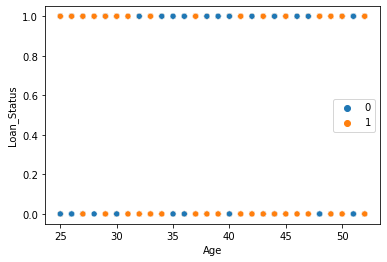

In [207]:
labels = KMeans(n_clusters=2,random_state=1)
clusters = labels.fit_predict(df.drop('Loan_Status',axis = 1))
sns.scatterplot(x = df['Age'],y= df['Loan_Status'],hue = clusters)

In [209]:
def clustering(x,tcol,cluster):
    column = list(set(list(x.columns)) - set(list('strength')))
    #column = x.columns
    r = int(len(column)/2)
    if len(column)%2 == 0:
        r = r
    else:
        r+= 1
    f,ax = plt.subplots(r,2,figsize = (15,15))
    a = 0
    for row in range(r):
        for col in range(2):
            if a != len(column):
                ax[row][col].scatter(x[tcol],x[column[a]],c=cluster)
                ax[row][col].set_xlabel(tcol)
                ax[row][col].set_ylabel(column[a])
                a += 1

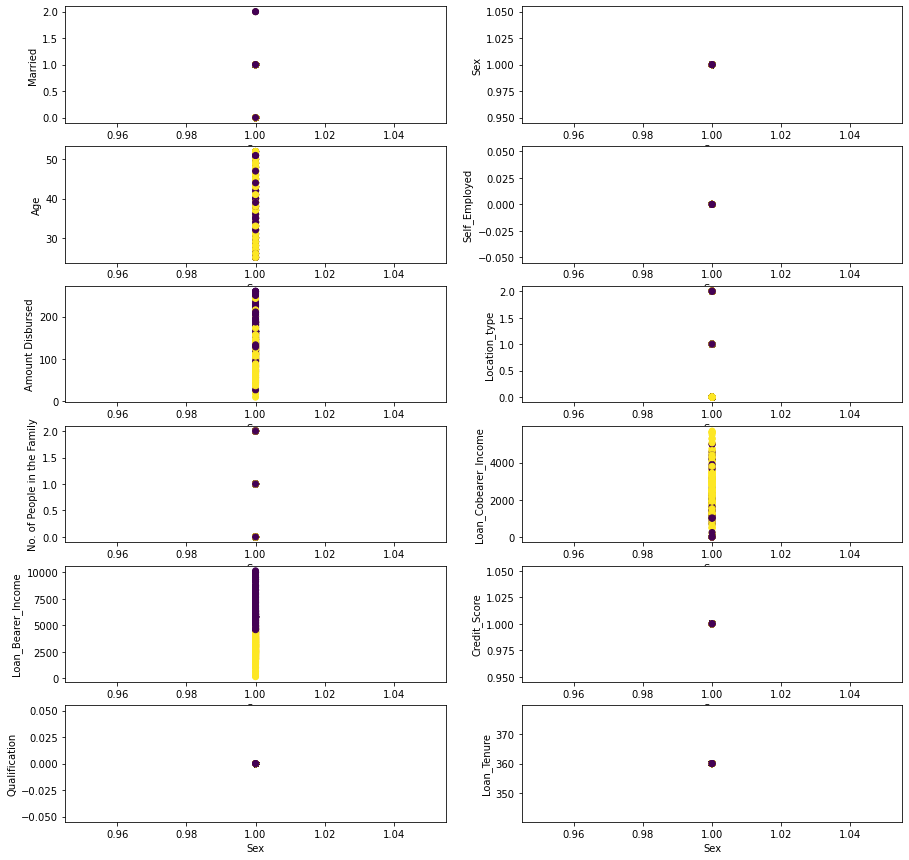

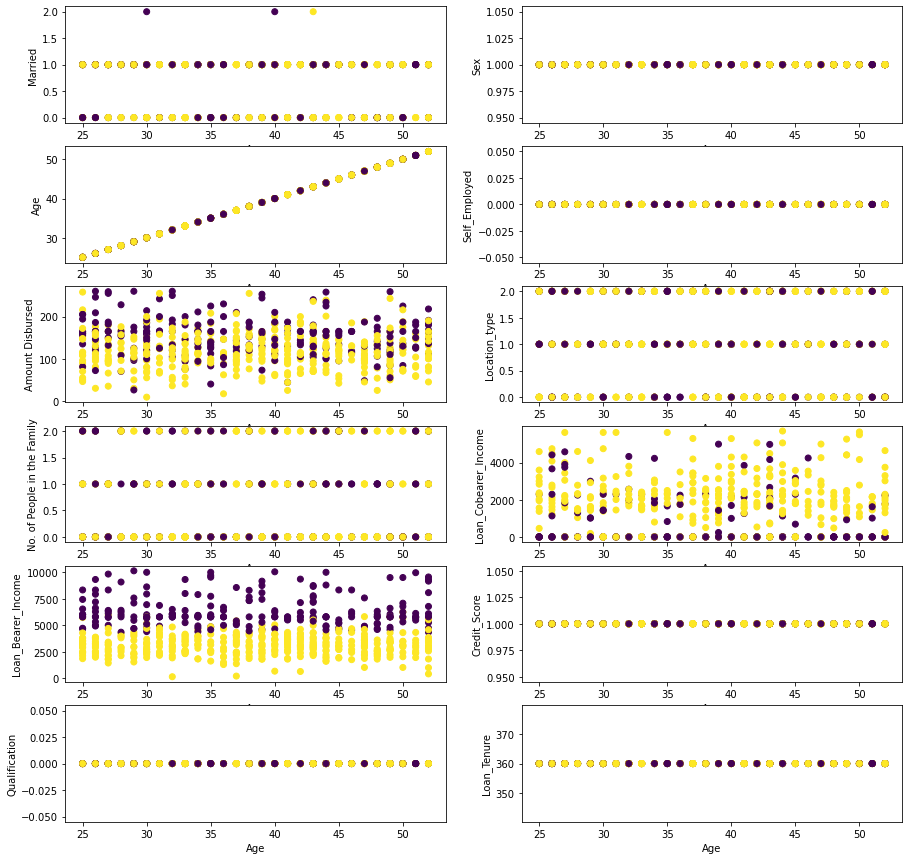

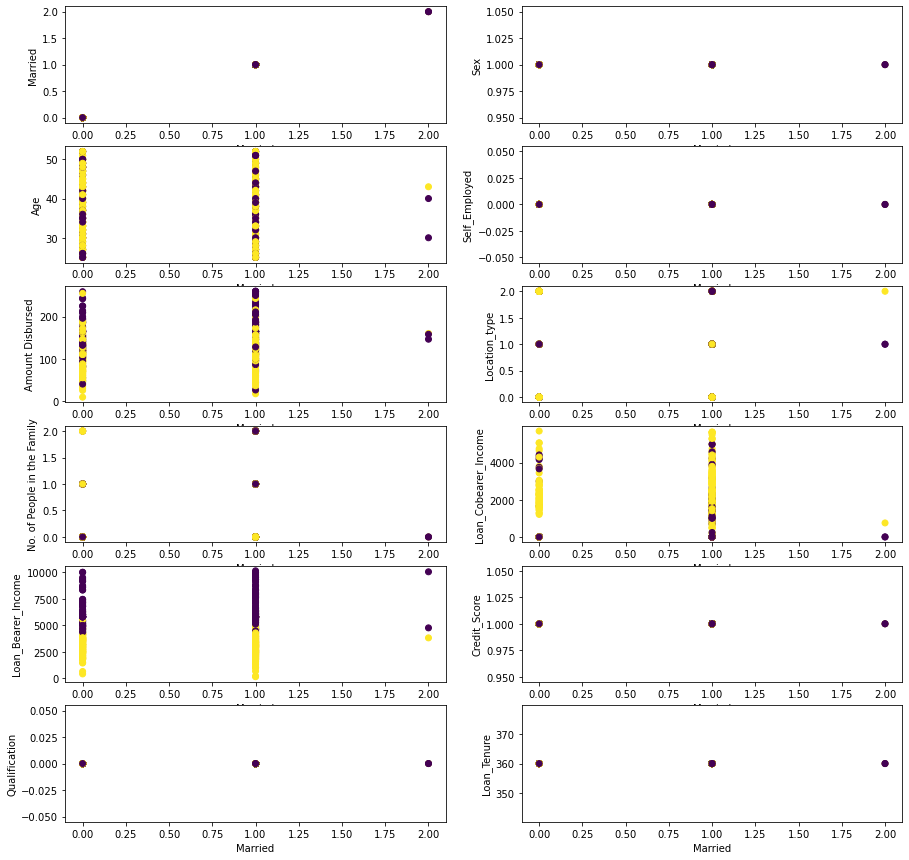

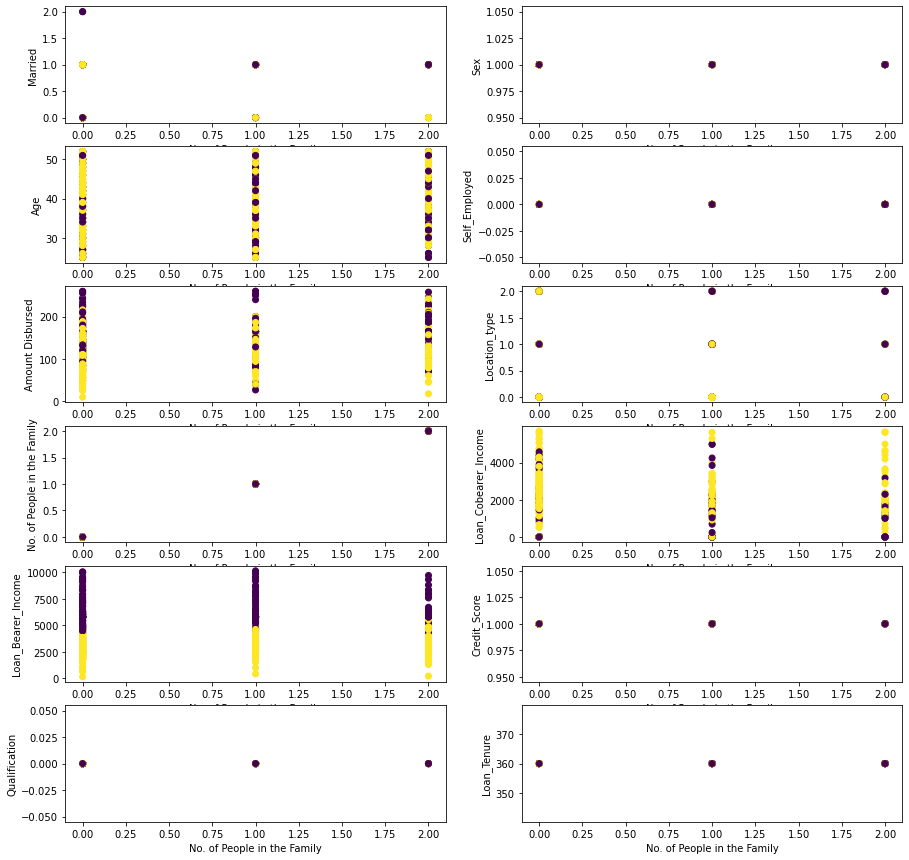

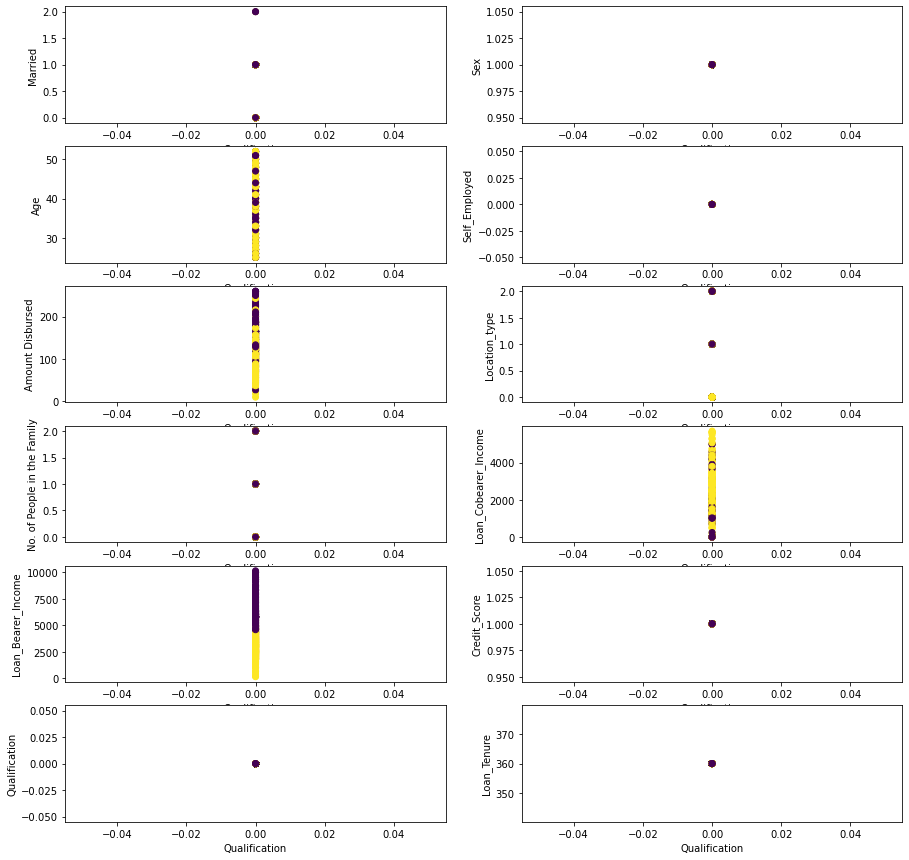

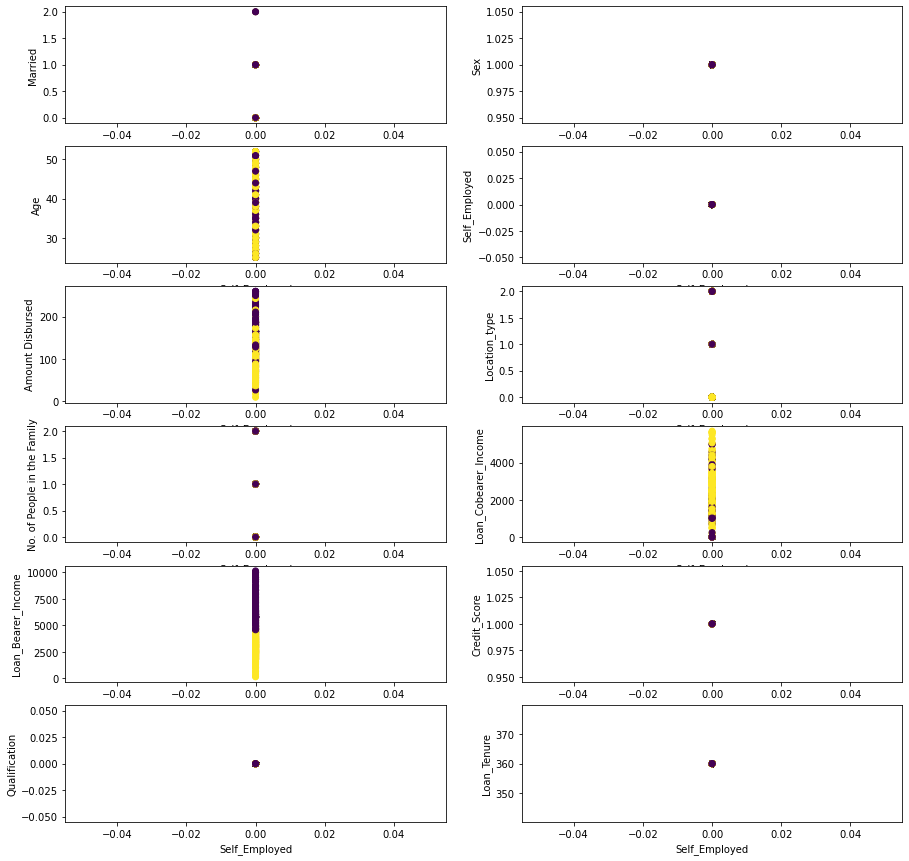

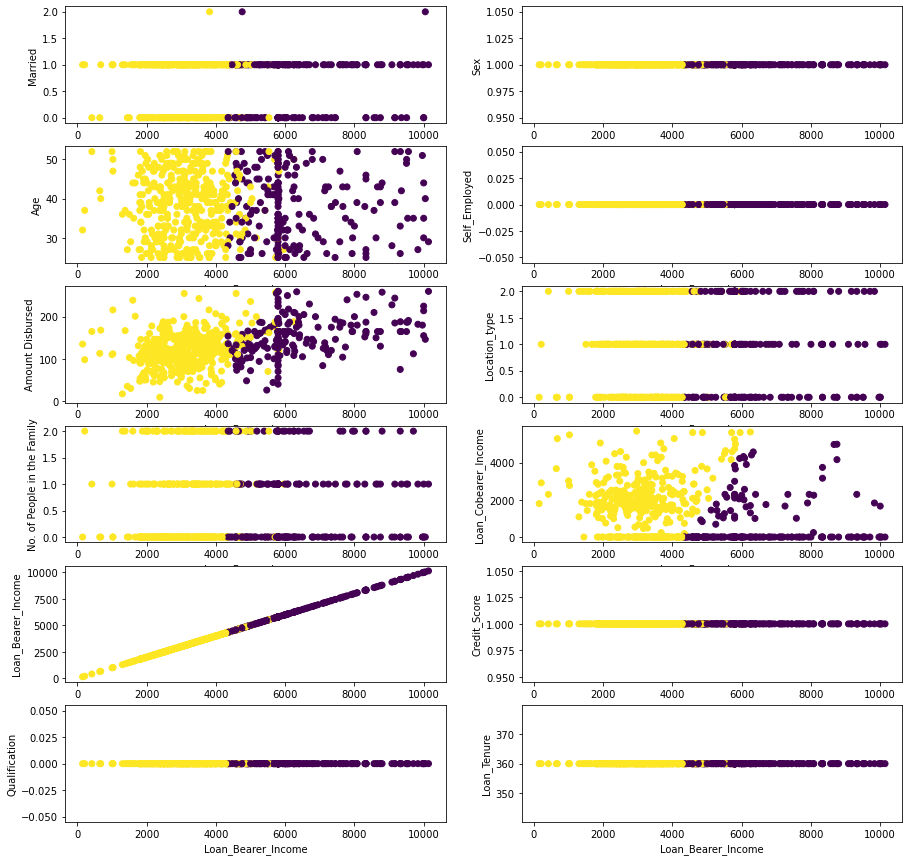

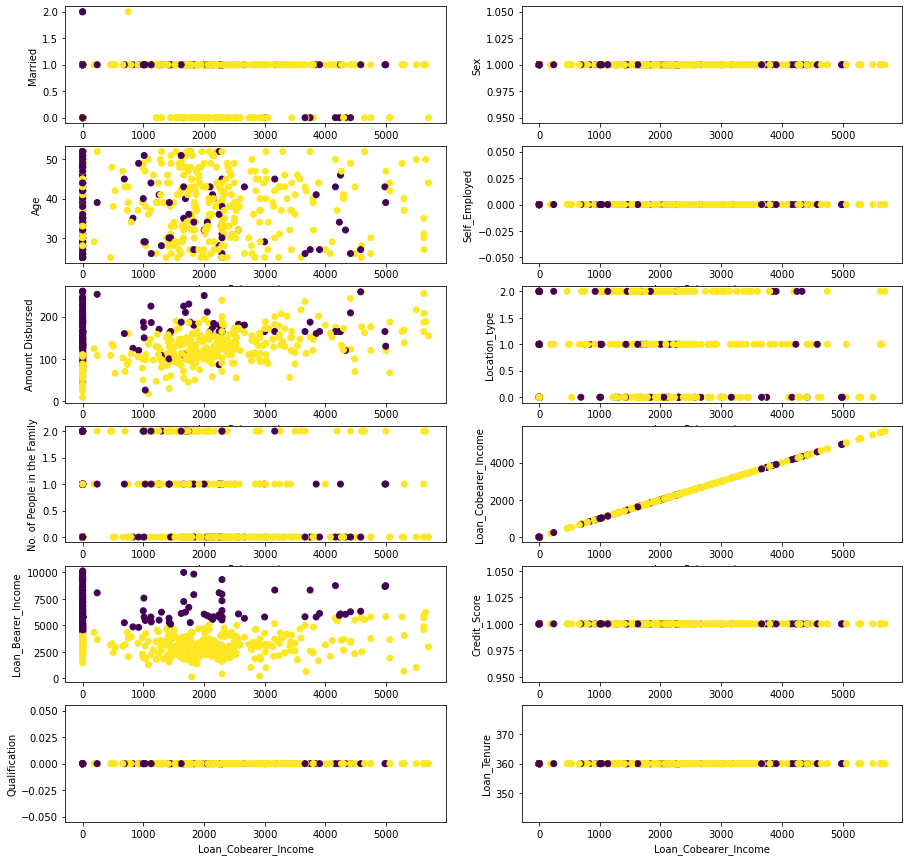

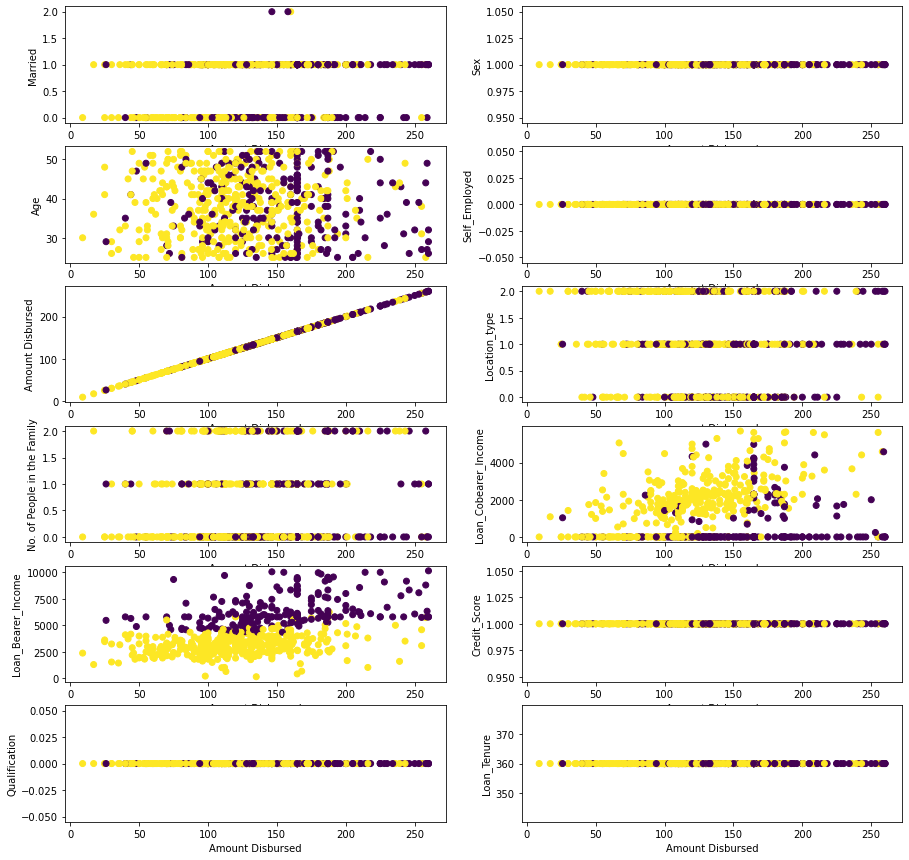

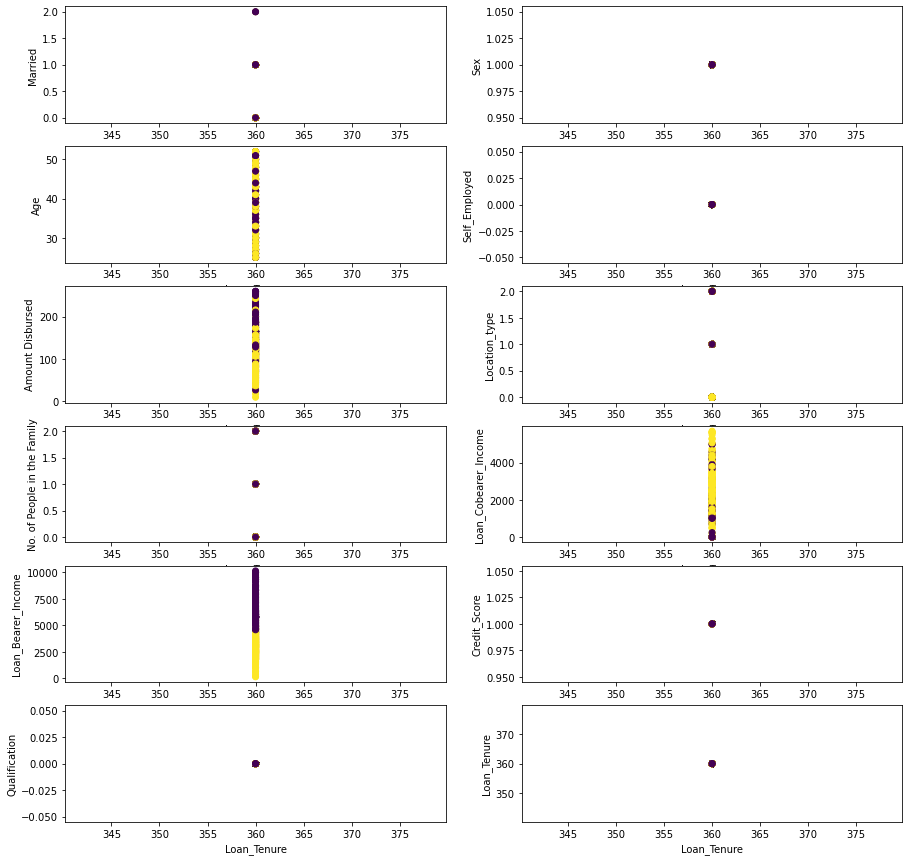

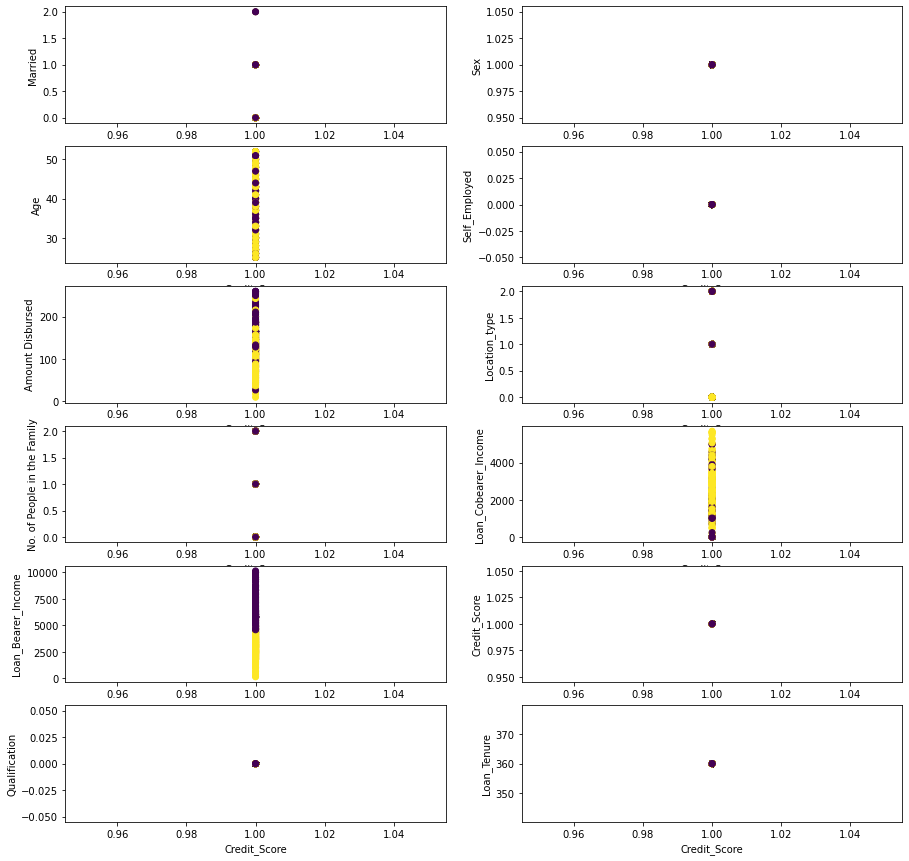

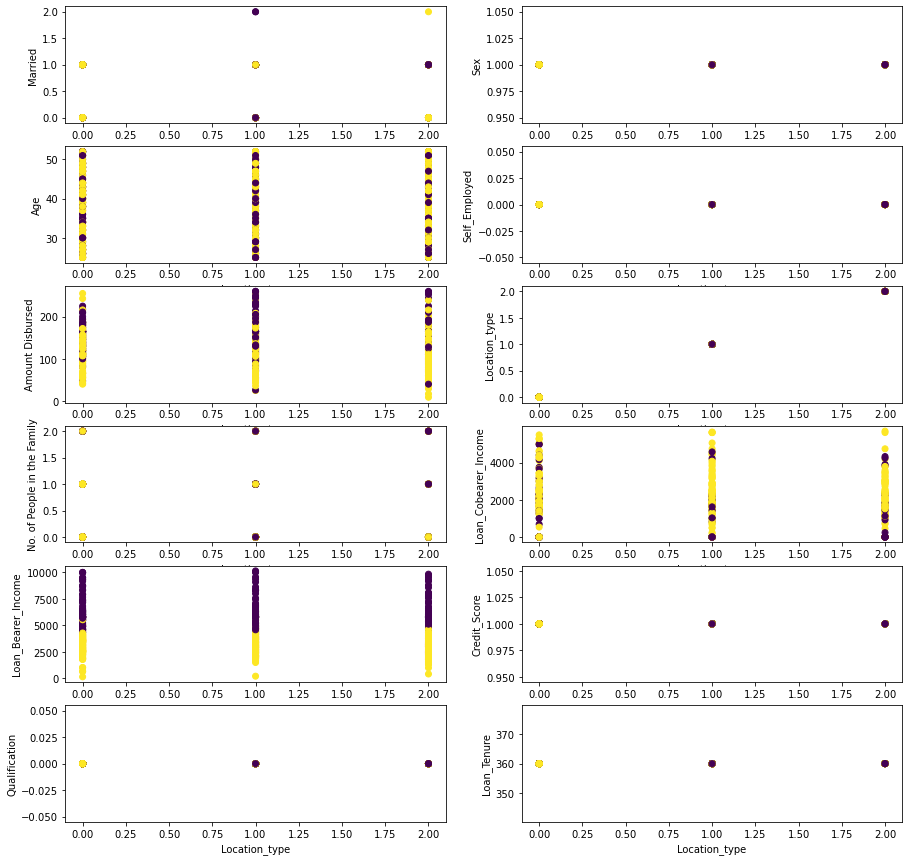

In [210]:
x = df.drop('Loan_Status',axis = 1)
for col in x.columns:
    clustering(x,col,clusters)

## Analysis 

- Cement is forming clear clusters with all the independent variable

In [211]:
new_df = df.join(pd.DataFrame(clusters,columns = ['cluster']), how = 'left')

In [212]:
list(clusters)

[0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,


In [213]:
new_df

,Sex,Age,Married,No. of People in the Family,Qualification,Self_Employed,Loan_Bearer_Income,Loan_Cobearer_Income,Amount Disbursed,Loan_Tenure,Credit_Score,Location_type,Loan_Status,cluster
0,1,33,0,0.0,0,0,5849.0,0.0,108.0,360.0,1.0,2,1,0
1,1,34,1,1.0,0,0,4583.0,1508.0,128.0,360.0,1.0,0,0,1
2,1,31,1,0.0,0,0,3000.0,0.0,66.0,360.0,1.0,2,1,1
3,1,33,1,0.0,0,0,2583.0,2358.0,120.0,360.0,1.0,2,1,1
4,1,48,0,0.0,0,0,6000.0,0.0,141.0,360.0,1.0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,1,28,0,0.0,0,0,2900.0,0.0,71.0,360.0,1.0,0,1,1
610,1,33,1,1.0,0,0,4106.0,0.0,40.0,360.0,1.0,0,1,1
611,1,39,1,1.0,0,0,8072.0,240.0,253.0,360.0,1.0,2,1,0
612,1,47,1,2.0,0,0,7583.0,0.0,187.0,360.0,1.0,2,1,0


In [214]:
new_f = new_df.groupby('cluster')['Age'].agg(['mean','median'])

In [216]:
new_f

,mean,median
cluster,,
0,38.186916,38.0
1,38.620000,39.0


In [217]:
cluster_df = new_df.merge(new_f,on = 'cluster',how = 'left')
cluster_df.head()

,Sex,Age,Married,No. of People in the Family,Qualification,Self_Employed,Loan_Bearer_Income,Loan_Cobearer_Income,Amount Disbursed,Loan_Tenure,Credit_Score,Location_type,Loan_Status,cluster,mean,median
0,1,33,0,0.0,0,0,5849.0,0.0,108.0,360.0,1.0,2,1,0,38.186916,38.0
1,1,34,1,1.0,0,0,4583.0,1508.0,128.0,360.0,1.0,0,0,1,38.620000,39.0
2,1,31,1,0.0,0,0,3000.0,0.0,66.0,360.0,1.0,2,1,1,38.620000,39.0
3,1,33,1,0.0,0,0,2583.0,2358.0,120.0,360.0,1.0,2,1,1,38.620000,39.0
4,1,48,0,0.0,0,0,6000.0,0.0,141.0,360.0,1.0,2,1,0,38.186916,38.0


### model evaluation on clustered dataframe

In [218]:
multiple_models(cluster_df,'Loan_Status')

,Model Name,accuracy score,precision score,recall score,F1 score
6,Gradient Boost Classifier,0.681081,0.701863,0.911290,0.792982
0,Log Regression,0.670270,0.670270,1.000000,0.802589
3,SVC,0.670270,0.670270,1.000000,0.802589
4,Random Forest Classifier,0.654054,0.676471,0.927419,0.782313
5,AdaBoost Classifier,0.643243,0.672619,0.911290,0.773973
2,KNeighborsClassifier,0.627027,0.672956,0.862903,0.756184
7,XGB Classifier,0.621622,0.677632,0.830645,0.746377
1,Decision Tree Classifier,0.508108,0.638655,0.612903,0.625514


In [219]:
KFoldCV(cluster_df.drop('Loan_Status',axis = 1),cluster_df['Loan_Status'])

,Model Name,CV Score,CV Stdev
3,SVC,0.687308,0.005314
0,Linear Classifier,0.685643,0.008084
5,AdaBoost Classifier,0.654680,0.049137
4,Random Forest Classifierr,0.648149,0.032603
6,Gradient Boost Classifier,0.641618,0.044333
2,K Neighbors Classifier,0.630381,0.034052
7,XGB Classifier,0.622158,0.038358
1,Decision Tree Classifier,0.561846,0.042679


# Feature Importance 

In [220]:
x_train,x_test,y_train,y_test = train_and_test_split(cluster_df,'Loan_Status')

In [221]:
x_train

,Sex,Age,Married,No. of People in the Family,Qualification,Self_Employed,Loan_Bearer_Income,Loan_Cobearer_Income,Amount Disbursed,Loan_Tenure,Credit_Score,Location_type,cluster,mean,median
81,1,51,1,1.0,0,0,2395.0,0.0,146.347386,360.0,1.0,1,1,38.620000,39.0
133,1,41,1,0.0,0,0,3459.0,0.0,25.000000,360.0,1.0,1,1,38.620000,39.0
400,1,52,1,2.0,0,0,2889.0,0.0,45.000000,360.0,1.0,2,1,38.620000,39.0
486,1,33,0,2.0,0,0,3547.0,0.0,80.000000,360.0,1.0,0,1,38.620000,39.0
161,1,26,1,0.0,0,0,7933.0,0.0,164.750000,360.0,1.0,2,0,38.186916,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,1,32,1,0.0,0,0,6080.0,2569.0,182.000000,360.0,1.0,0,0,38.186916,38.0
144,1,38,1,2.0,0,0,5795.0,0.0,187.000000,360.0,1.0,2,0,38.186916,38.0
72,1,32,0,0.0,0,0,3500.0,0.0,81.000000,360.0,1.0,1,1,38.620000,39.0
235,1,41,1,1.0,0,0,5500.0,1260.0,170.000000,360.0,1.0,0,0,38.186916,38.0


In [223]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

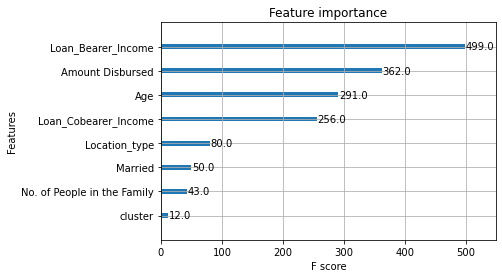

In [224]:
xgboost.plot_importance(xgb)

In [230]:
subset_df = cluster_df[['Loan_Bearer_Income','Amount Disbursed','Age','Loan_Cobearer_Income','Loan_Status']]

'Loan_Bearer_Income','Amount Disbursed','Age','Loan_Cobearer_income'

In [231]:
KFoldCV(subset_df.drop('Loan_Status',axis = 1),subset_df['Loan_Status'])

,Model Name,CV Score,CV Stdev
3,SVC,0.687308,0.005314
0,Linear Classifier,0.685669,0.006959
5,AdaBoost Classifier,0.654548,0.033376
6,Gradient Boost Classifier,0.638392,0.023307
4,Random Forest Classifierr,0.636727,0.054449
2,K Neighbors Classifier,0.630381,0.034052
7,XGB Classifier,0.607377,0.036476
1,Decision Tree Classifier,0.554997,0.074262


we have considered 4 features and dropped 4 features ie 50% of the actual data
still we can observe only 1% decrease in the CV score which is huge advantage 

## Learning Curve Analysis

In [232]:
def generate_learning_curve(model_name,estimator,x,y):
    train_size,train_score,test_score = learning_curve(estimator,x,y,cv = 10)
#     print('train_size',train_size)
#     print('train_score',train_score)
#     print('test_score',test_score)
    train_score_mean = np.mean(train_score,axis = 1)
    test_score_mean = np.mean(test_score,axis=1)
    plt.plot(train_size,train_score_mean,c='blue')
    plt.plot(train_size,test_score_mean,c='red')
    plt.xlabel('Samples')
    plt.ylabel('Scores')
    plt.title("Learning Curve for "+model_name)
    plt.legend(('Training accuracy',"Testing accuracy"))

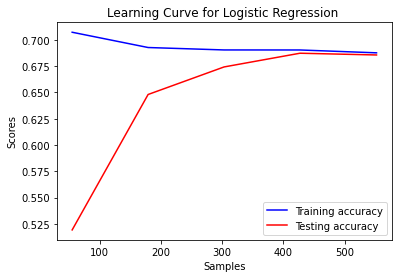

In [233]:
generate_learning_curve('Logistic Regression ',LogisticRegression(),cluster_df.drop('Loan_Status',axis = 1),cluster_df['Loan_Status'])

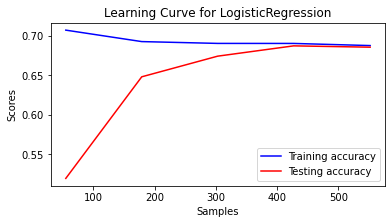

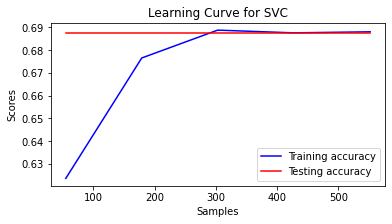

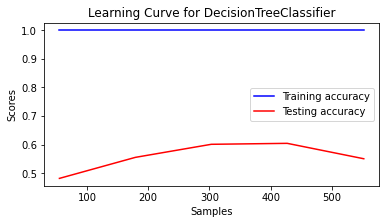

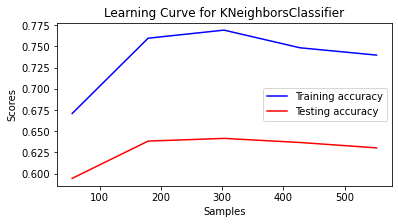

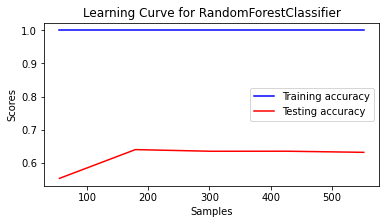

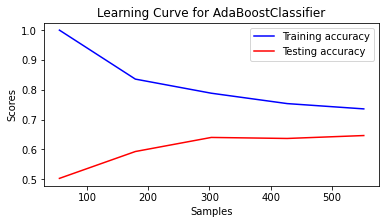

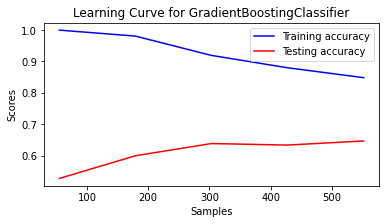

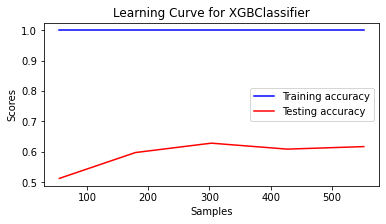

In [234]:
model_names = [LogisticRegression(),SVC(),DecisionTreeClassifier(),KNeighborsClassifier(),
              RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier(),XGBClassifier()]
for i,model in enumerate(model_names):
#     print(i)
#     print(model)
    fg = plt.figure(figsize = (6,3))
    ax = fig.add_subplot(5,2,i+1)
    generate_learning_curve(type(model).__name__,model,cluster_df.drop('Loan_Status',axis = 1),cluster_df['Loan_Status'])